In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
import sys
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *
from Models.SimpleRNN_NC import SimpleRNN_NC

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

## Load data

In [3]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [4]:
baseline_df = df.loc[df.type == 'BASELINE'].reset_index()

In [5]:
stim_df = df.loc[df.type == 'TONIC'].reset_index()

In [6]:
X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b, info_train_b, info_val_b, info_test_b = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, info_train_s, info_val_s, info_test_s = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)
# Test one of the folds first
fold_num = 'fold1'
fold = 1



print('We are testing the optimization method on fold ', fold)

def input_mats(x,y, seq_length = 75):
    x = x[fold_num]
    y = y[fold_num]
    x = x.reshape(x.shape[0] // seq_length, seq_length, x.shape[1])  
    y = y.reshape(y.shape[0] // seq_length, seq_length, y.shape[1])  
    return x,y

x_train_base, y_train_base = input_mats(X_train_b, y_train_b)
x_train_stim, y_train_stim = input_mats(X_train_s, y_train_s)

x_val_base, y_val_base = input_mats(X_val_b, y_val_b)
x_val_stim, y_val_stim = input_mats(X_val_s, y_val_s)

x_test_base, y_test_base = input_mats(X_test_b, y_test_b)
x_test_stim, y_test_stim = input_mats(X_test_s, y_test_s)

seed = 42
torch.manual_seed(seed)

Test trials  4
Val trials 3
Test trials  8
Val trials 7
We are testing the optimization method on fold  1


## Model

In [7]:
def create_state_dict(param_names, param_values):
    s_d = {}
    for n,v in zip(param_names, param_values):
        s_d[n] = v
    return s_d

In [8]:
import torch
import torch.nn as nn

class dev_model(nn.Module):
    def __init__(self,  hnet_output, 
                    num_features=124, 
                    hidden_size= 3, #was 128
                    #initial_offset = -2,
                    num_layers = 2, 
                    input_size = 50,
                    out_dims = 6, 
                    dropout_1 = 0.3, 
                    dropout_2 = 0.3, 
                    bias = True,
                    LSTM_ = False):
        
        super(dev_model, self).__init__()
        self.num_features = num_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hnet_output = hnet_output
        self.bias = bias
        self.out_features = out_dims
        self.LSTM_ = LSTM_

        self.dropout1 = nn.Dropout(p= dropout_1) #trial.suggest_float('dropout_1', 0.1, 0.9)
        self.dropout2 = nn.Dropout(p= dropout_2)

        # Define recurrent layer
        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, self.bias, batch_first = True, bidirectional = False)
        names_p = [name for name, _ in self.rnn.named_parameters()]
        self.hnet_output_dict = create_state_dict(names_p,hnet_output[4:] )

        # Initialize CustomRNN
        if self.LSTM_:
            self.rnn = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, self.bias, batch_first = True, bidirectional = False)
            names_p = [name for name, _ in self.rnn.named_parameters()]
            self.hnet_output_dict = create_state_dict(names_p,hnet_output[4:] )            

    def forward(self, x, hx=None):
        x = F.linear(x, self.hnet_output[0], bias=self.hnet_output[1])
        x = self.dropout1(x)
        # Forward pass
        if hx is None:
            if self.LSTM_:
                h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) * 0.1
                c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) *0.1 # Initialize cell state
                hx = (h0, c0)
            else:
                hx = torch.randn(self.num_layers, x.size(0), self.hidden_size, device=x.device) * 0.1

        # Perform RNN operation
        x, _  = torch.func.functional_call(self.rnn, self.hnet_output_dict, (x, hx))
        #self.lstm.flatten_parameters()  # Add this line to flatten parameters
        #x, _ = self.lstm(x) 
        x = self.dropout2(x)
        output =  F.linear(x, self.hnet_output[2], bias=self.hnet_output[3])
        # Apply sigmoid activation function
        output = torch.sigmoid(output)
        
        return output.squeeze() 


In [9]:
hidden_size = 20
input_size = 40
output_size = 3
input_features = 127

In [10]:
LSTM_ = False
param_shapes = [[input_size, input_features], [input_size], [output_size, hidden_size], [output_size], [hidden_size, input_size], [hidden_size, hidden_size], [hidden_size], [hidden_size]]

if LSTM_ == True:
    param_shapes = [[input_size, input_features], [input_size], [output_size, hidden_size], [output_size], [hidden_size*4, input_size], [hidden_size*4, hidden_size], [hidden_size*4], [hidden_size*4]]
#param_shapes = [[50, 127], [50], [3, 22], [3], [22, 50], [22, 22], [22],[22]]



In [11]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 8

hnet = HMLP(param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[30], 
            num_cond_embs=num_conditions).to(device)

Created MLP Hypernet.
Hypernetwork with 199399 weights and 6423 outputs (compression ratio: 31.04).
The network consists of 199383 unconditional weights (199383 internally maintained) and 16 conditional weights (16 internally maintained).


In [12]:
num_dim_output = y_train_base.shape[2]
num_features = x_train_base.shape[2]

# Hyperparameters LSTM class
num_layers = 1


In [13]:
for param in hnet.parameters():
    param.requires_grad = True

In [14]:
w_test = hnet(cond_id = 0)

In [15]:
model = dev_model(num_features= num_features, hnet_output = w_test,  hidden_size = hidden_size,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.1, dropout_2= 0.1, LSTM_ = False).to(device)

In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
""" # Set up the optimizer with the specified learning rate
optimizer = torch.optim.Adam(hnet.internal_params, lr= 0.001)

# Set up a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, 
                                step_size=10, 
                                gamma=0.9)

# Keep track of the best model's parameters and loss
best_model_wts = deepcopy(hnet.state_dict())
best_loss = 1e8

# Enable anomaly detection for debugging
torch.autograd.set_detect_anomaly(True)

# Track the train and validation loss
train_losses = []
val_losses = []
# Counters for early stopping
not_increased = 0
end_train = 0


sequence_length_LSTM = 10
batch_size_train = batch_size_val = 25


# Reshape data for the LSTM
train_dataset_baseline = SequenceDataset(
y_train_base,    x_train_base,    sequence_length=sequence_length_LSTM)

train_dataset_stim = SequenceDataset(
y_train_stim,    x_train_stim,    sequence_length=sequence_length_LSTM)

val_dataset_baseline = SequenceDataset(
y_val_base,    x_val_base,    sequence_length=sequence_length_LSTM)

val_dataset_stim = SequenceDataset(
y_val_stim,    x_val_stim,    sequence_length=sequence_length_LSTM)

loader_train_b = data.DataLoader(train_dataset_baseline, batch_size=batch_size_train, shuffle=True)
loader_train_s = data.DataLoader(train_dataset_stim, batch_size=batch_size_train, shuffle=True)

loader_val_b = data.DataLoader(val_dataset_baseline, batch_size=batch_size_val, shuffle=True)
loader_val_s = data.DataLoader(val_dataset_stim, batch_size=batch_size_val, shuffle=True)



# Loop through epochs
for epoch in np.arange(25):
    for phase in ['train', 'val']:
        # set model to train/validation as appropriate
        if phase == 'train':
            model.train()
            loaders = zip(loader_train_b, loader_train_s)
        else:
            model.eval()
            loaders = zip(loader_val_b, loader_val_s)

        # Initialize variables to track loss and batch size
        running_loss = 0
        running_size = 0      

        # Initialize h0 and c0 outside the model
        h0 = torch.zeros(num_layers, batch_size_train, model.hidden_size).to(device)
        c0 = torch.zeros(num_layers, batch_size_train, model.hidden_size).to(device)
        hx = (h0, c0)  

        # Iterate over batches in the loader
        for data_b, data_s in loaders:

            # Define data for this batch
            x_b = data_b[0].to('cuda')
            y_b = data_b[1].to('cuda')
            x_s = data_s[0].to('cuda')
            y_s = data_s[1].to('cuda')

            if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        # Compute BASELINE loss.
                        W_base = hnet(cond_id=0)  
       
                        model = dev_model(num_features= num_features, hnet_output = W_base,  hidden_size = hidden_units,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2).to(device)
                                    
                        base_P = model(x_b, hx)
                   
                        loss_base = huber_loss(base_P, y_b, delta = 8)
                        
                        loss_base.backward()
                        #print(hnet.unconditional_params[-1])
                        # Iterate over parameters of hnet and compute gradients
                        # Iterate over parameters of hnet and compute gradients
                       
                        for name, param in hnet.named_parameters():
                            if param.requires_grad:
                                print("Gradient for {}: {}".format(name, param.grad))

                        
                        optimizer.step()
            else:
                # just compute the loss in validation phase
                W_base = hnet(cond_id=0)
                model = dev_model(num_features= num_features, hnet_output = W_base,  hidden_size = hidden_units,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2).to(device)
                                    
                base_P = model(x_b, hx)
                
                loss_base = huber_loss(base_P, y_b, delta = 8)

               
            # Ensure the loss is finite
            assert torch.isfinite(loss_base)
            assert torch.isfinite(loss_base)
            running_loss += loss_base.item()
            running_size += 1

        # compute the train/validation loss and update the best
        # model parameters if this is the lowest validation loss yet
        running_loss /= running_size
        if phase == "train":
            train_losses.append(running_loss)
        else:
            val_losses.append(running_loss)
            # Update best model parameters if validation loss improves
            if running_loss < best_loss:
                best_loss = running_loss
                best_model_wts = deepcopy(model.state_dict())
                not_increased = 0
            else:
                # Perform early stopping if validation loss doesn't improve
                if epoch > 10:
                    not_increased += 1
                    # print('Not increased : {}/5'.format(not_increased))
                    if not_increased == 5:
                        print('Decrease LR')
                        for g in optimizer.param_groups:
                            g['lr'] = g['lr'] / 2
                        not_increased = 0
                        end_train += 1
                    
                    if end_train == 2:
                        model.load_state_dict(best_model_wts)
                       
    scheduler.step()
    
    print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1])) """


' # Set up the optimizer with the specified learning rate\noptimizer = torch.optim.Adam(hnet.internal_params, lr= 0.001)\n\n# Set up a learning rate scheduler\nscheduler = lr_scheduler.StepLR(optimizer, \n                                step_size=10, \n                                gamma=0.9)\n\n# Keep track of the best model\'s parameters and loss\nbest_model_wts = deepcopy(hnet.state_dict())\nbest_loss = 1e8\n\n# Enable anomaly detection for debugging\ntorch.autograd.set_detect_anomaly(True)\n\n# Track the train and validation loss\ntrain_losses = []\nval_losses = []\n# Counters for early stopping\nnot_increased = 0\nend_train = 0\n\n\nsequence_length_LSTM = 10\nbatch_size_train = batch_size_val = 25\n\n\n# Reshape data for the LSTM\ntrain_dataset_baseline = SequenceDataset(\ny_train_base,    x_train_base,    sequence_length=sequence_length_LSTM)\n\ntrain_dataset_stim = SequenceDataset(\ny_train_stim,    x_train_stim,    sequence_length=sequence_length_LSTM)\n\nval_dataset_baseline

In [18]:
def reg_test(weights, alpha, l1_ratio):
    
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: MLP
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    l1_loss = 0
    l2_loss = 0

    # Accumulate L1 and L2 losses for weight matrices in the model
    for weight_tensor in weights[2]:
        l1_loss += torch.sum(torch.abs(weight_tensor))
        l2_loss += torch.sum(weight_tensor.pow(2))

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    # Accumulate L1 and L2 losses for weight matrices in the model
    for weight_tensor in weights:
        l1_loss += torch.sum(torch.abs(weight_tensor))
        l2_loss += torch.sum(weight_tensor.pow(2))

    reg_item = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg_item = alpha * reg_item

    return reg

In [ ]:
self._param_shapes_meta.append({
        'name': 'bias' if is_bias else 'weight',
        'index': -1 if self._no_weights else \
            len(self._weights)-1,
        'layer': i * 2 + num_prev_layers, # Odd numbers
    })


In [35]:
model.param_shapes_meta = [{
    'name': 'weight',
    'index':0,
    'layer': 0
}, 
{
    'name': 'bias',
    'index':1,
    'layer': 0
}, 
{
    'name': 'weight',
    'index':2,
    'layer': 2
}, 
{
    'name': 'bias',
    'index':3,
    'layer': 2
}, 
{
    'name': 'weight',
    'index':4,
    'layer': 1
}, 
{
    'name': 'weight',
    'index':5,
    'layer': 1
}, 
{
    'name': 'bias',
    'index':6,
    'layer': 1
}, 
{
    'name': 'bias',
    'index':7,
    'layer': 1
}, ]

In [36]:
def train_hypernet(model, hnet,y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=10,
                batch_size_train = 25,
                batch_size_val = 25,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                chunks = False
                
                ):

    
    # Initialize the hypernetwork

    # --> this was only when using th models from hypnettorch
    """     if chunks:
         hnet.apply_chunked_hyperfan_init(mnet = model)
    else: 
         hnet.apply_hyperfan_init(mnet=model) """
    hnet.apply_hyperfan_init(mnet=model)

    # Set up the optimizer with the specified learning rate
    optimizer = torch.optim.Adam(hnet.internal_params, lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
    
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset_baseline = SequenceDataset(
    y_train_base,    x_train_base,    sequence_length=sequence_length_LSTM)

    train_dataset_stim = SequenceDataset(
    y_train_stim,    x_train_stim,    sequence_length=sequence_length_LSTM)

    val_dataset_baseline = SequenceDataset(
    y_val_base,    x_val_base,    sequence_length=sequence_length_LSTM)

    val_dataset_stim = SequenceDataset(
    y_val_stim,    x_val_stim,    sequence_length=sequence_length_LSTM)

    loader_train_b = data.DataLoader(train_dataset_baseline, batch_size=batch_size_train, shuffle=True)
    loader_train_s = data.DataLoader(train_dataset_stim, batch_size=batch_size_train, shuffle=True)

    loader_val_b = data.DataLoader(val_dataset_baseline, batch_size=batch_size_val, shuffle=True)
    loader_val_s = data.DataLoader(val_dataset_stim, batch_size=batch_size_val, shuffle=True)

    # Initialize h0 and c0 outside the model
    if LSTM_ == True:

        h0 = torch.randn(num_layers, batch_size_train, hidden_size, device=device) * 0.1
        c0 = torch.randn(num_layers, batch_size_train, hidden_size, device=device) *0.1 # Initialize cell state
        hx = (h0, c0) 
    else:
        hx = torch.randn(num_layers, batch_size_train, hidden_size, device=device) * 0.1
    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loaders = zip(loader_train_b, loader_train_s)
            else:
                model.eval()
                loaders = zip(loader_val_b, loader_val_s)

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for data_b, data_s in loaders:

                # Define data for this batch
                x_b = data_b[0].to('cuda')
                y_b = data_b[1].to('cuda')
                x_s = data_s[0].to('cuda')
                y_s = data_s[1].to('cuda')
               
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        # Compute BASELINE loss.
                        W_base = hnet(cond_id=0)
                        model = dev_model(num_features= num_features, hnet_output = W_base,  hidden_size = hidden_size,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2, LSTM_ = False).to(device)
                                    
                        base_P = model(x_b, hx)
                        
                        loss_base = huber_loss(base_P, y_b, delta = delta)
                        
                        
                        # Compute STIMULATION loss.
                        W_stim = hnet(cond_id=1)
                        model = dev_model(num_features= num_features, hnet_output = W_stim,  hidden_size = hidden_size,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2, LSTM_ = False).to(device)          
                        stim_P = model(x_b, hx)
                        loss_stim = huber_loss(stim_P, y_s, delta = delta)
                        
                        # Combine loss for 2 tasks
                        loss_t = loss_base + loss_stim    #only for printing

                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            loss_stim_reg = loss_stim + reg_test(W_stim, l1_ratio, alpha)
                            loss_base_reg = loss_base + reg_test(W_base, l1_ratio, alpha)
                            # Combine loss for 2 tasks
                            loss_t_r = loss_base_reg + loss_stim_reg

                        else:               
                            loss_t_r = loss_t 
                        
                        

                        # Compute gradients and perform an optimization step
                        loss_t_r.backward()
                        optimizer.step()


                else:
                    # just compute the loss in validation phase
                    W_base = hnet(cond_id=0)
                    model = dev_model(num_features= num_features, hnet_output = W_base,  hidden_size = hidden_size,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2, LSTM_ = False).to(device)          
                    base_P = model(x_b, hx)
                    loss_base = huber_loss(base_P, y_b, delta = delta)

                    W_stim = hnet(cond_id=1)
                    model = dev_model(num_features= num_features, hnet_output = W_stim,  hidden_size = hidden_size,
                            num_layers= num_layers, input_size = input_size,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.2, LSTM_ = False).to(device)          
                    stim_P = model(x_b, hx)
                    loss_stim = huber_loss(stim_P, y_s, delta = delta)

                    loss_t = loss_base + loss_stim

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                assert torch.isfinite(loss_t_r)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses), W_base, W_stim

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses), W_base, W_stim

In [37]:
t_losses, val_losses, W_base, W_stim = train_hypernet(model, hnet,y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.0001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM=15,
                batch_size_train = 5,
                batch_size_val = 5,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=None,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                chunks = False)

AssertionError: 

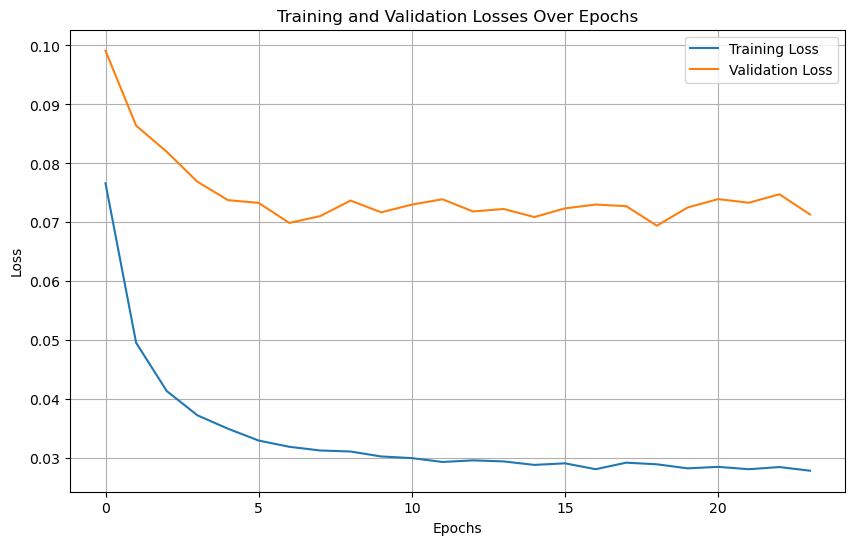

In [26]:
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(t_losses, val_losses)

In [27]:
def calc_explained_variance(x, y, mnet):
    """Compute the explained variance for a given dataset"""
    with torch.no_grad():
        # Process complete dataset as one batch.
        # Convert X_train and y_train to PyTorch tensors
        inputs = torch.tensor(x, device=device, dtype=torch.float32)
        targets = torch.tensor(y, device=device, dtype=torch.float32)

        # Forward pass to get predictions
        predictions = mnet(inputs)

        y_array = targets.detach().cpu().numpy()
        y_pred_array = predictions.detach().cpu().numpy()
     
        # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
        y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
        y_true_2D = y_array.reshape(-1, y_array.shape[-1])

        # Compute explained variance
        explained_var = r2_score(y_true_2D, y_pred_2D)

    return explained_var

In [28]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[x_train_base, y_train_base],
             [x_val_base, y_val_base],
             [x_test_base, y_test_base]]

data_stim = [[x_train_stim, y_train_stim],
             [x_val_stim, y_val_stim],
             [x_test_stim, y_test_stim]]

In [29]:
for index, [x,y] in enumerate(data_base):
    ev = calc_explained_variance(x, y, model)
    print('Explained variance for ', subsets[index], ' is : ', ev)


Explained variance for  Training  is :  -1.5990448532477342
Explained variance for  Validation  is :  -0.5150845599717658
Explained variance for  Test  is :  -1.022689295875334


In [30]:
for index, [x,y] in enumerate(data_stim):
    ev = calc_explained_variance(x, y, model)
    print('Explained variance for ', subsets[index], ' is : ', ev)

Explained variance for  Training  is :  -1.9380712869097536
Explained variance for  Validation  is :  -0.8536884339811207
Explained variance for  Test  is :  -1.1597706395312246
